## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
%matplotlib inline
import datetime as dt
# import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import re
import pingouin as pg

C:\ProgramData\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.

C:\ProgramData\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.



## Configuration

In [2]:
init_notebook_mode(connected=True)

# For offline use
# cf.go_offline()

#Graph configuration
#plt.rcParams.keys()
plt.rcParams['font.size']=25 #valores
plt.rcParams['xtick.labelsize']=30 # barras
plt.rcParams['axes.titlesize']=45 #titulo
plt.rcParams['axes.labelsize']=35 #eixos


In [3]:
with open('BASE ESTUDO - CLEAN COVID GERAL - STRAVA.csv', 'r', encoding="utf-8", errors="surrogateescape") as f:
    data = f.read()

In [4]:
data=re.sub(r'""',';',data) #substituir 2 aspas por ;
data=re.sub(r'"','',data)   #substituir 1 aspa por vazio
data=re.sub(r"'",'"',data)  #substituir apóstrafo por aspas
data=re.sub('\[','',data)   #substituir colchetes por vazio
data=re.sub('\]','',data)   #substituir colchetes por vazio
data=re.sub(r',,',',NaN',data) #substituir 2 virgulas por vírgula e NaN
data=re.sub(r' ','',data) #substituir espaço por vazio
data=re.sub(r';','"',data) #substituir ; por aspas
data=re.sub(r'""','"',data) #substituir 2 aspas por 1 aspa
data = re.sub(r'(\d+)\.(\d+)(k|m)', r'\1\2\3', data) #remover pontos do milhar
data = re.sub(r'(\d+)\.(\d+)\,(\d+)(k|m)', r'\1\2,\3\4', data) #remover pontos do milhar
data = re.sub(r'(\d+)(h)(\d+)(min)', r'\1:\3:00', data) #remover "h" por":" e adição ":00"
data = re.sub(r'(\d+),(\d+)(k|m)', r'\1.\2\3', data) #substituir "," por "."
data = re.sub(r'(\d+)(km|m)', r'\1', data) #remover km e m
data = re.sub(r'(\d+):(\d+)(/km)', r'00:\1:\2', data) #remover /km do pace
#data = re.sub(r'(/km)', '', data) #remover /km do pace

In [5]:
with open('novabase.csv', 'w', encoding="utf-8", errors="surrogateescape") as w:
    w.write(data)

# Official Information

## Load DataFrame with each year result
The data will be translated to English

In [6]:
df_athletes = pd.read_csv("novabase.csv",low_memory=False, error_bad_lines=False, warn_bad_lines=True)

In [7]:
df_athletes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27328 entries, 0 to 27327
Data columns (total 82 columns):
classificacao    27197 non-null float64
nome             27328 non-null object
ano              27328 non-null object
pace             27328 non-null object
fc               27328 non-null object
tempo_liquido    27328 non-null object
faixa_etaria     27328 non-null object
sexo             27328 non-null object
segmento         27328 non-null object
atleta           27328 non-null object
k201901          5679 non-null float64
t201901          5679 non-null object
a201901          5679 non-null float64
k201902          5679 non-null object
t201902          5679 non-null object
a201902          5679 non-null float64
k201903          5679 non-null float64
t201903          5679 non-null object
a201903          5679 non-null float64
k201904          5679 non-null float64
t201904          5679 non-null object
a201904          5679 non-null float64
k201905          5679 non-null float6

## Conversion Time - from 's' to "00:00"

In [8]:
def convert_time (x):
    m=(divmod(x,3600)[1])/60
    h=divmod(x,3600)[0]
    
    if round(m,0)==60:
        return '{h:0>2.0f}:{m:0>2.0f}'.format(h=h+1,m=0)
    else:
        return '{h:0>2.0f}:{m:0>2.0f}'.format(h=h,m=m)

In [9]:
convert_time(272000)

'75:33'

## Make all times, timedeltas

In [10]:
def convert_pace (x):
    x=str(x)
    if x!='nan':
        
        splitx = x.split(":")
        hora=""
        minuto=""
        segundo=""

        if len(splitx[0])!=2:
            hora="0"+splitx[0]
        else:
            hora=splitx[0]

        if len(splitx[1])!=2:
            minuto="0"+splitx[1]
        else:
            minuto=splitx[1]

        if len(splitx[2])!=2:
            segundo="0"+splitx[2]
        else:
            segundo=splitx[2]

        time = hora+":"+minuto+":"+segundo
        
        time=pd.to_timedelta(time)
        return time
    else:
        return x
    
    #print(time)

In [11]:
df_athletes['pace']=df_athletes['pace'].apply(lambda x: convert_pace(x))

In [12]:
for column in range(11,81,3):
    df_athletes.iloc[:,column]=df_athletes.iloc[:,column].apply(lambda x: convert_pace(x))

## All athletes

Text(0.5, 1.0, 'Athletes')

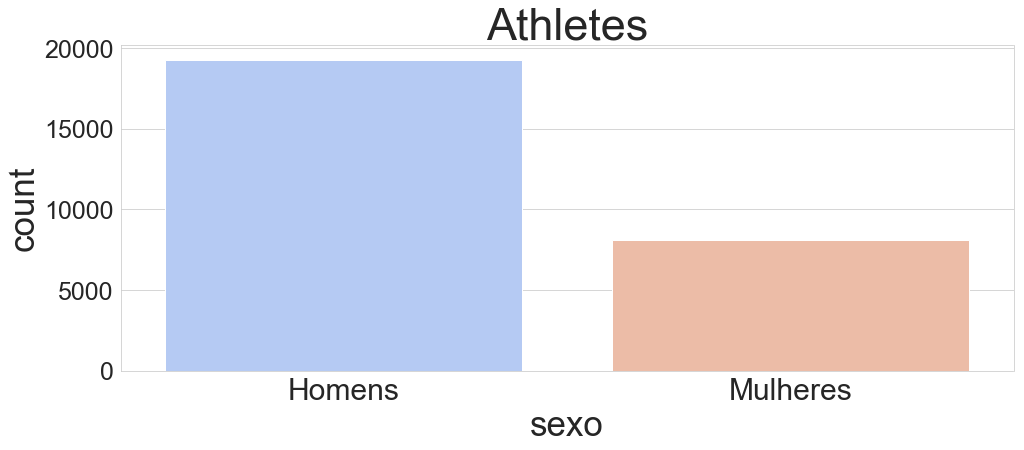

In [13]:
fig=plt.figure(figsize=(16,6))
graph = sns.countplot(x='sexo',data=df_athletes,palette='coolwarm')
graph.set_title("Athletes")

In [14]:
df_athletes['sexo'].value_counts()

Homens      19244
Mulheres     8084
Name: sexo, dtype: int64

## Athletes with details

Text(0.5, 1.0, 'Athletes')

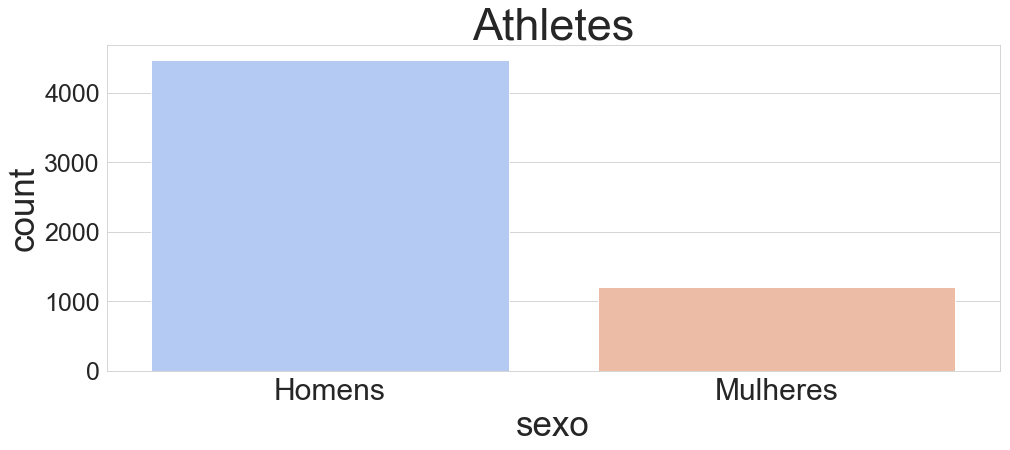

In [15]:
df_athletes_filter=df_athletes[df_athletes['k201901'].isnull()==False]
df_athletes.reset_index(inplace=True)

filterbug=(df_athletes_filter['t201901']<'0 days')|(df_athletes_filter['t201902']<'0 days')|(df_athletes_filter['t201903']<'0 days')|(df_athletes_filter['t201904']<'0 days')|(df_athletes_filter['t201905']<'0 days')|(df_athletes_filter['t201906']<'0 days')|(df_athletes_filter['t201907']<'0 days')|(df_athletes_filter['t201908']<'0 days')|(df_athletes_filter['t201909']<'0 days')|(df_athletes_filter['t201910']<'0 days')|(df_athletes_filter['t201911']<'0 days')|(df_athletes_filter['t201912']<'0 days')|(df_athletes_filter['t202001']<'0 days')|(df_athletes_filter['t202002']<'0 days')|(df_athletes_filter['t202003']<'0 days')|(df_athletes_filter['t202004']<'0 days')
df_athletes_filter=df_athletes_filter.drop(index=df_athletes_filter[filterbug].index,inplace=False)

fig=plt.figure(figsize=(16,6))
graph = sns.countplot(x='sexo',data=df_athletes_filter,palette='coolwarm')
graph.set_title("Athletes")

In [16]:
df_athletes_filter['sexo'].value_counts()

Homens      4471
Mulheres    1205
Name: sexo, dtype: int64

In [17]:
def age_group(oldrange):
    if (oldrange=='19eabaixo')or(oldrange=='20a24')or(oldrange=='25a34')or(oldrange=='35a44'):
        return 'Young'
    else:
        return 'Older'

In [18]:
df_athletes_filter['age_group']=df_athletes_filter['faixa_etaria'].apply(lambda x: age_group(x))

In [19]:
df_athletes_filter.iloc[0][0:19]

classificacao                                               NaN
nome                                               BrunoBianchi
ano                                               20demaide2018
pace                                            0 days 00:03:47
fc                                                       182bpm
tempo_liquido                                             38:34
faixa_etaria                                          19eabaixo
sexo                                                     Homens
segmento         https://strava.com/segment_efforts/40157732655
atleta                     https://strava.com/athletes/25692127
k201901                                                   109.2
t201901                                         0 days 08:21:00
a201901                                                    1340
k201902                                                   135.7
t201902                                         0 days 10:44:00
a201902                                 

In [20]:
df_athletes_filter.sort_values(by='faixa_etaria')['faixa_etaria'].value_counts()

25a34        2214
35a44        1293
55a64        1034
45a54         776
20a24         145
65a69          98
19eabaixo      83
75+            20
70a74          13
Name: faixa_etaria, dtype: int64

In [54]:
"""1 - choose the gender {Homens, Mulheres,both}
   2 - comparison {comp_2019apr_2020apr,comp_2020jan_2020apr,all}
   3 - choose age_group {Young, Older, all}
   
   
   """

def graph_boxplot_time (gender,months,age_group):
    
    if(age_group=='Young'):
        filter2=(df_athletes_filter.faixa_etaria!='19eabaixo')&(df_athletes_filter.faixa_etaria!='45a54')&(df_athletes_filter.age_group=='Young')
        age_group='Young athletes'
    if(age_group=='Older'):
        filter2=(df_athletes_filter.faixa_etaria!='19eabaixo')&(df_athletes_filter.faixa_etaria!='45a54')&(df_athletes_filter.age_group=='Older')
        age_group='Older athletes'
    if(age_group=='all'):
        filter2=(df_athletes_filter.age_group=='Young') |(df_athletes_filter.age_group=='Older')
        age_group='All athletes'
    
    if(months=='all'):
        time_columns=[11,14,17,20,23,26,29,32,35,38,41,44,47,50,53,56]
        months=' - 2019 and 2020'
    if(months=='comp_2019apr_2020apr'):
        time_columns=[20,56]
        months=' - 2019 april x 2020 april'
    if(months=='comp_2019jan_2020jan'):
        time_columns=[11,47]
        months=' - 2019 january x 2020 january'
    if(months=='comp_2020jan_2020apr'):
        time_columns=[47,56]
        months=' - 2020 january x april'
        
        
    if(gender=='male'):
        filter1=(df_athletes_filter['sexo']=='Homens')
        gender='- male - '
    if(gender=='female'):
        filter1=(df_athletes_filter['sexo']=='Mulheres')
        gender='- female - '
    if(gender=='all'):
        filter1=(df_athletes_filter['sexo']=='Homens')|(df_athletes_filter['sexo']=='Mulheres')
        gender='- male and female - '
    
    graph_name='Distribution of training time '+ gender + age_group+months
    
    data=pd.concat([pd.melt(df_athletes_filter[(filter1)&(filter2)].iloc[:,time_columns])['variable'],pd.melt(df_athletes_filter[(filter1)&(filter2)].iloc[:,time_columns])['value'].apply(lambda x: x.total_seconds())],axis=1)
    data.rename(inplace=True, columns={'variable':'Months','value':'Time (HH:MM)'})
    
    
    
    #Graph configuration
    #plt.rcParams.keys()
    plt.rcParams['font.size']=30 #valores
    plt.rcParams['xtick.labelsize']=35 # barras
    plt.rcParams['axes.titlesize']=38 #titulo
    plt.rcParams['axes.labelsize']=35 #eixos
    #plt.xticks(rotation='vertical')
    #plt.xticks(x, labels, rotation='vertical')


    fig=plt.figure(figsize=(25,10))
    #data_m=df_results[df_results['M/F']=='m'].sort_values(by='Age_Group')
    graph = sns.boxplot( x='Months',y='Time (HH:MM)',data=data, palette="coolwarm",)
    #graph.set_xticklabels(labels='Months',rotation=90)
    #graph.set_xticklabels(graph.get_xticklabels(), rotation=90, horizontalalignment='center')
    graph.set_ylim([0, 198000]) 
    #graph.set_title(graph_name)
    #graph.legend(labels=[graph_name],loc=8)
    import matplotlib.patches as mpatches
    #red_patch = mpatches.Patch(label=graph_name)
    
   # graph.legend(handles=[red_patch],loc=1)
    
    ylabels=[convert_time(y) for y in graph.get_yticks()]
    graph.set_yticklabels(ylabels)
    
    
    return pd.concat([data.groupby(['Months']).describe().iloc[:,0],data.groupby(['Months']).describe().iloc[:,1:-1]/3600],axis=1)
  


Time (HH:MM)                                                       
               count       mean          std  min  25%       50%        75%
Months                                                                     
t201901       5676.0   9.059373    14.752521  0.0  0.0  5.216667  12.733333
t201902       5676.0   8.342639    19.084663  0.0  0.0  4.383333  11.616667
t201903       5676.0  10.714597    71.501175  0.0  0.0  5.416667  14.250000
t201904       5676.0   9.960682    58.535795  0.0  0.0  5.166667  12.704167
t201905       5676.0   9.793693    28.289611  0.0  0.0  5.466667  13.287500
t201906       5676.0   9.662603    27.849703  0.0  0.0  5.691667  13.520833
t201907       5676.0   8.824580    13.696459  0.0  0.0  4.733333  12.733333
t201908       5676.0   9.219864    26.719975  0.0  0.0  4.866667  12.466667
t201909       5676.0   8.765906    15.703450  0.0  0.0  4.941667  12.066667
t201910       5676.0  10.028295    55.755112  0.0  0.0  5.100000  12.450000
t201911       5676.0   8.210656    16.278472  0.0  0.0  4.966667  11.750000
t201912       5676.0   7.986314    11.503341  0.0  0.0  4.691667  11.616667
t202001       5676.0   8.778121    17.591809  0.0  0.0  5.000000  12.400000
t202002       5676.0  68.844218  4567.027545  0.0  0.0  4.358333  12.366667
t202003       5676.0   7.519682    10.500214  0.0  0.0  3.783333  11.133333
t202004       5676.0   7.090842    11.435769  0.0  0.0  1.866667  10.483333

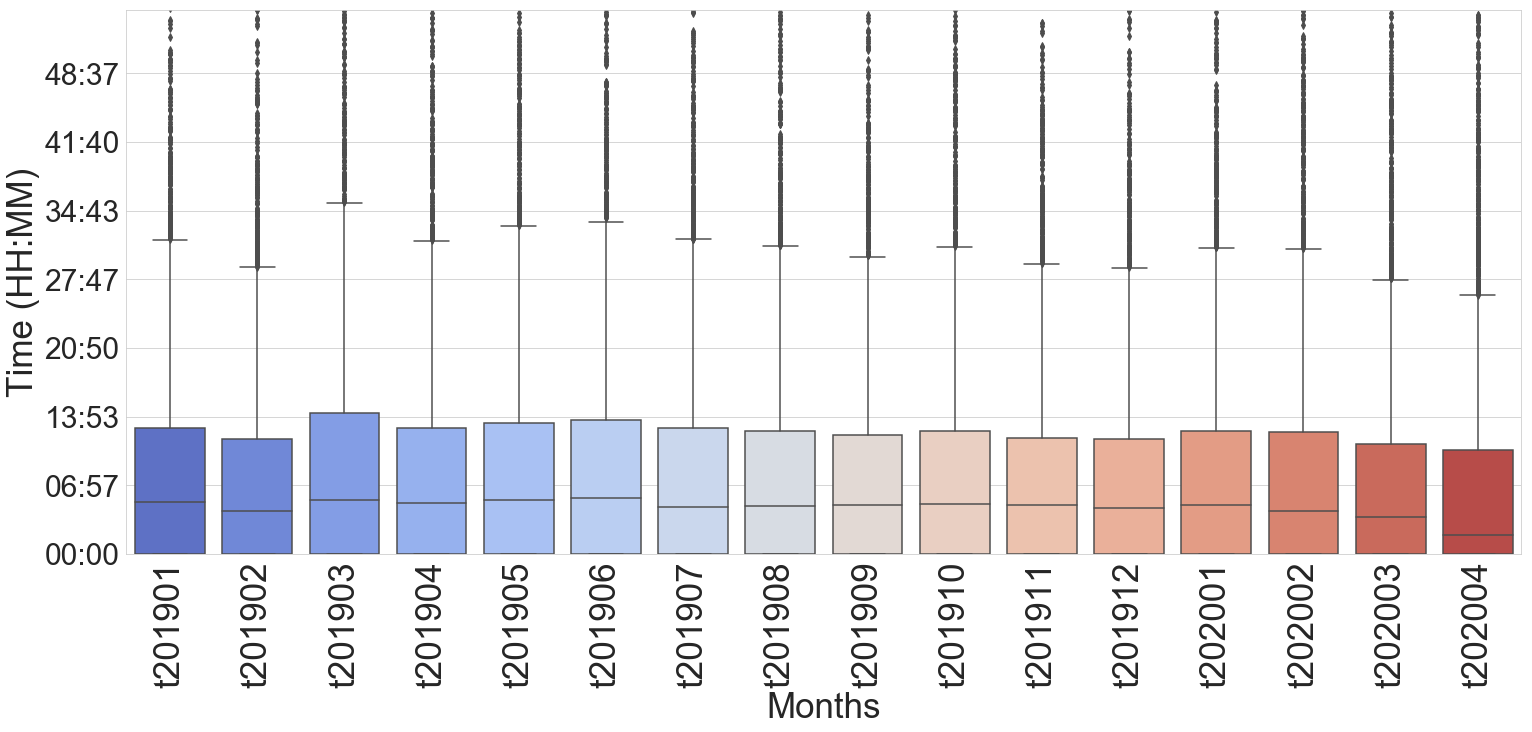

In [52]:
graph_boxplot_time('all','all','all')

Time (HH:MM)                                                   \
               count       mean          std  min       25%       50%   
Months                                                                  
t201901       4471.0   9.438821    13.080266  0.0  0.416667  5.900000   
t201902       4471.0   8.506147    13.782393  0.0  0.000000  4.850000   
t201903       4471.0  11.385115    79.702540  0.0  0.000000  6.000000   
t201904       4471.0  10.670558    65.643316  0.0  0.000000  5.750000   
t201905       4471.0   9.833132    17.655696  0.0  0.300000  5.850000   
t201906       4471.0   9.725363    17.474393  0.0  0.216667  6.283333   
t201907       4471.0   9.247003    13.909062  0.0  0.000000  5.383333   
t201908       4471.0   9.376698    24.067375  0.0  0.000000  5.466667   
t201909       4471.0   9.024294    15.072102  0.0  0.000000  5.333333   
t201910       4471.0  10.515034    62.044531  0.0  0.075000  5.600000   
t201911       4471.0   8.596742    17.649811  0.0  0.000000  5.400000   
t201912       4471.0   8.276359    10.873604  0.0  0.000000  5.116667   
t202001       4471.0   9.298315    19.068516  0.0  0.041667  5.383333   
t202002       4471.0  85.724979  5145.784618  0.0  0.000000  5.000000   
t202003       4471.0   7.987822    10.710639  0.0  0.000000  4.383333   
t202004       4471.0   7.488623    11.691182  0.0  0.000000  2.433333   

                    
               75%  
Months              
t201901  13.316667  
t201902  12.350000  
t201903  15.000000  
t201904  13.325000  
t201905  13.950000  
t201906  14.141667  
t201907  13.525000  
t201908  13.133333  
t201909  12.583333  
t201910  12.891667  
t201911  12.291667  
t201912  12.075000  
t202001  13.066667  
t202002  13.283333  
t202003  11.758333  
t202004  11.200000

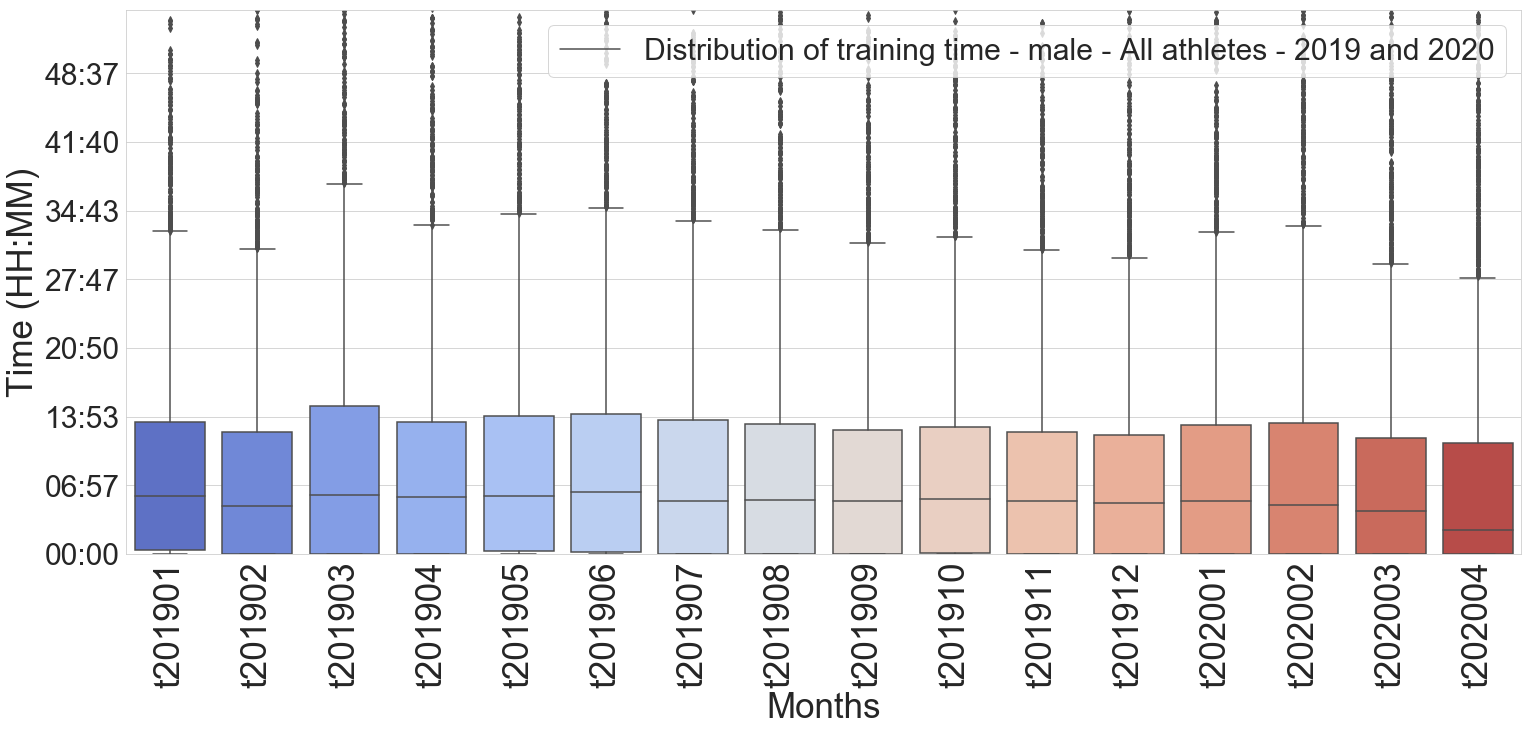

In [43]:
graph_boxplot_time('male','all','all')

Time (HH:MM)                                                    
               count      mean        std  min  25%       50%        75%
Months                                                                  
t201901       1205.0  7.651480  19.700197  0.0  0.0  3.483333  10.066667
t201902       1205.0  7.735961  31.797143  0.0  0.0  2.966667   9.000000
t201903       1205.0  8.226722  22.469101  0.0  0.0  3.650000  10.733333
t201904       1205.0  7.326777  11.986959  0.0  0.0  3.516667  10.033333
t201905       1205.0  9.647358  51.135586  0.0  0.0  4.066667  11.283333
t201906       1205.0  9.429737  50.220004  0.0  0.0  4.050000  11.183333
t201907       1205.0  7.257234  12.760802  0.0  0.0  3.216667   9.633333
t201908       1205.0  8.637953  34.846507  0.0  0.0  3.183333   9.683333
t201909       1205.0  7.807192  17.826160  0.0  0.0  3.350000   9.816667
t201910       1205.0  8.222310  18.879069  0.0  0.0  3.450000  10.600000
t201911       1205.0  6.778133   9.479637  0.0  0.0  3.000000  10.250000
t201912       1205.0  6.910138  13.538170  0.0  0.0  3.166667   9.333333
t202001       1205.0  6.848008  10.198370  0.0  0.0  3.300000   9.716667
t202002       1205.0  6.210290   9.229755  0.0  0.0  2.366667   9.016667
t202003       1205.0  5.782711   9.483783  0.0  0.0  1.983333   7.783333
t202004       1205.0  5.614924  10.304730  0.0  0.0  0.500000   6.933333

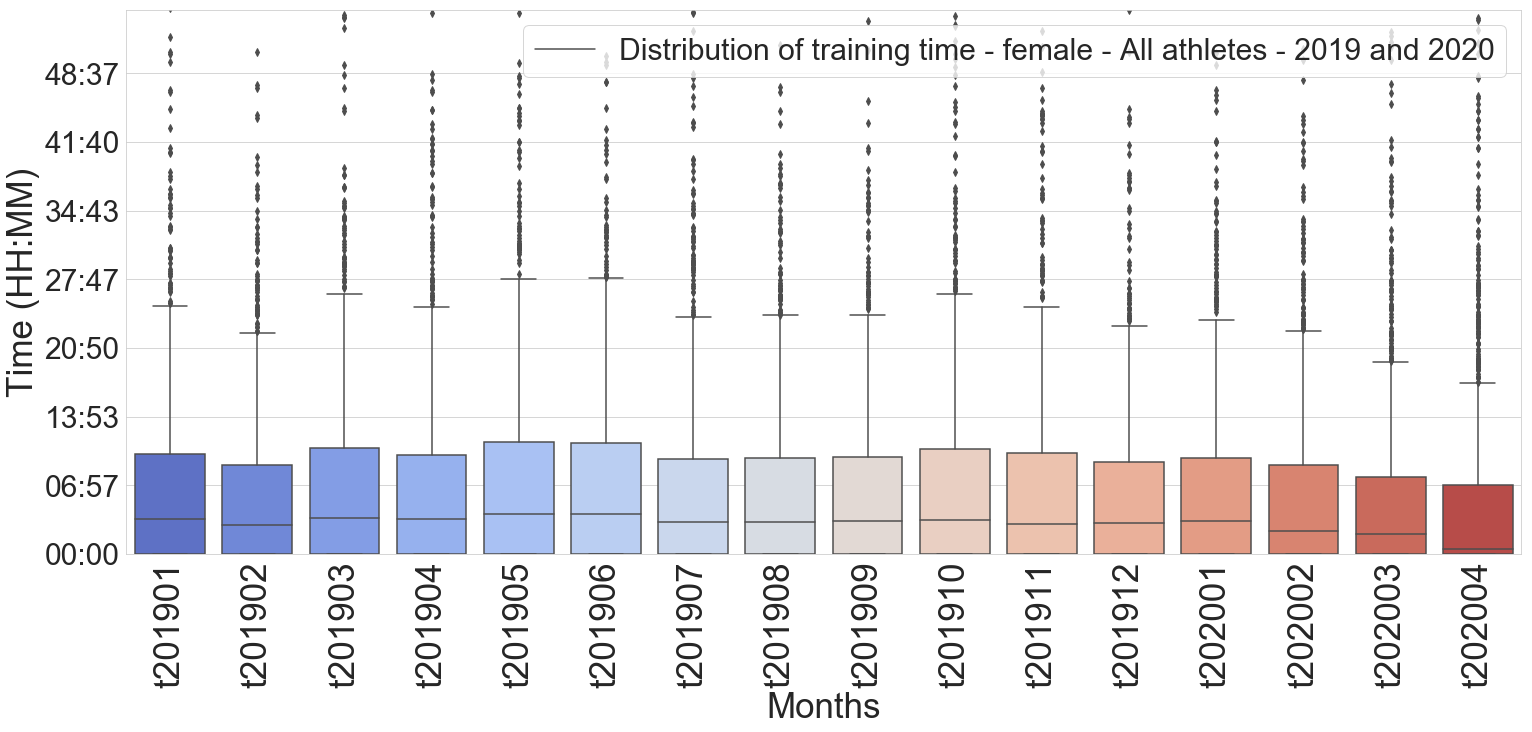

In [44]:
graph_boxplot_time('female','all','all')

Time (HH:MM)                                                    
               count      mean        std  min  25%       50%        75%
Months                                                                  
t201904       5676.0  9.960682  58.535795  0.0  0.0  5.166667  12.704167
t202004       5676.0  7.090842  11.435769  0.0  0.0  1.866667  10.483333

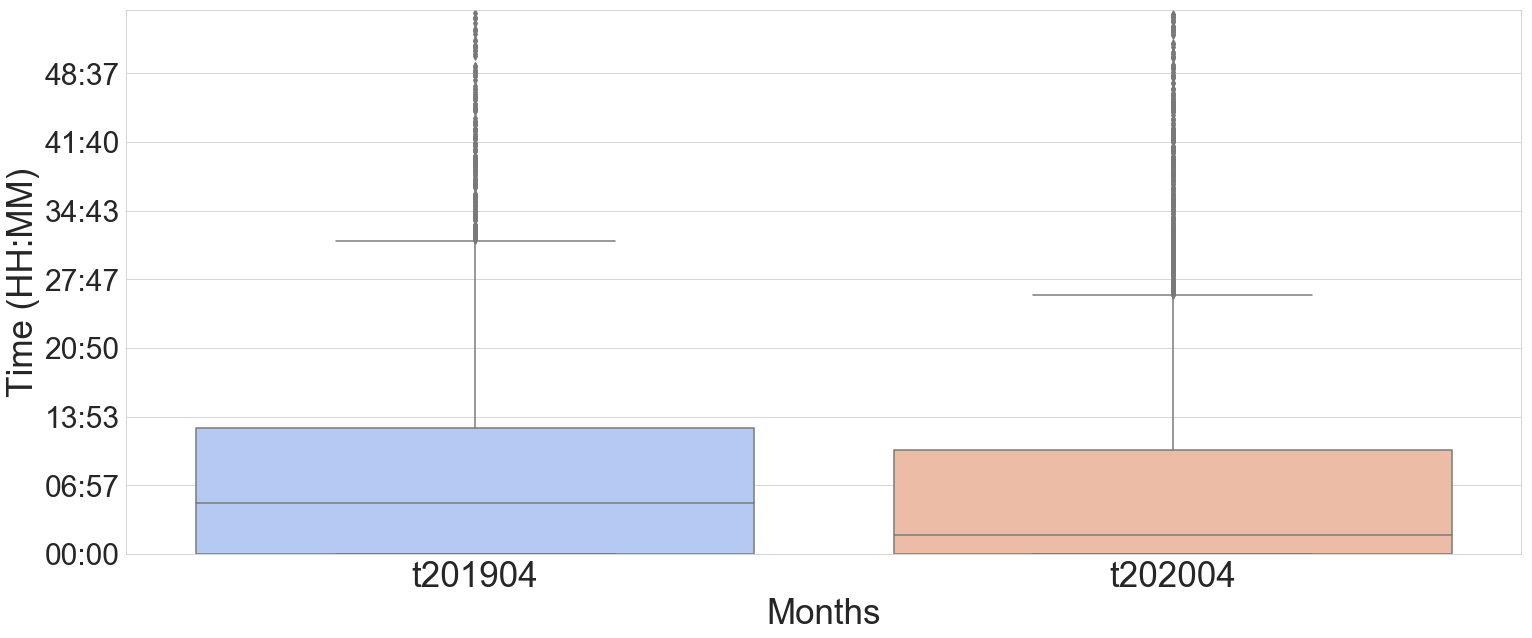

In [57]:
graph_boxplot_time('all','comp_2019apr_2020apr','all')

Time (HH:MM)                                                    
               count      mean        std  min  25%       50%        75%
Months                                                                  
t202001       5676.0  8.778121  17.591809  0.0  0.0  5.000000  12.400000
t202004       5676.0  7.090842  11.435769  0.0  0.0  1.866667  10.483333

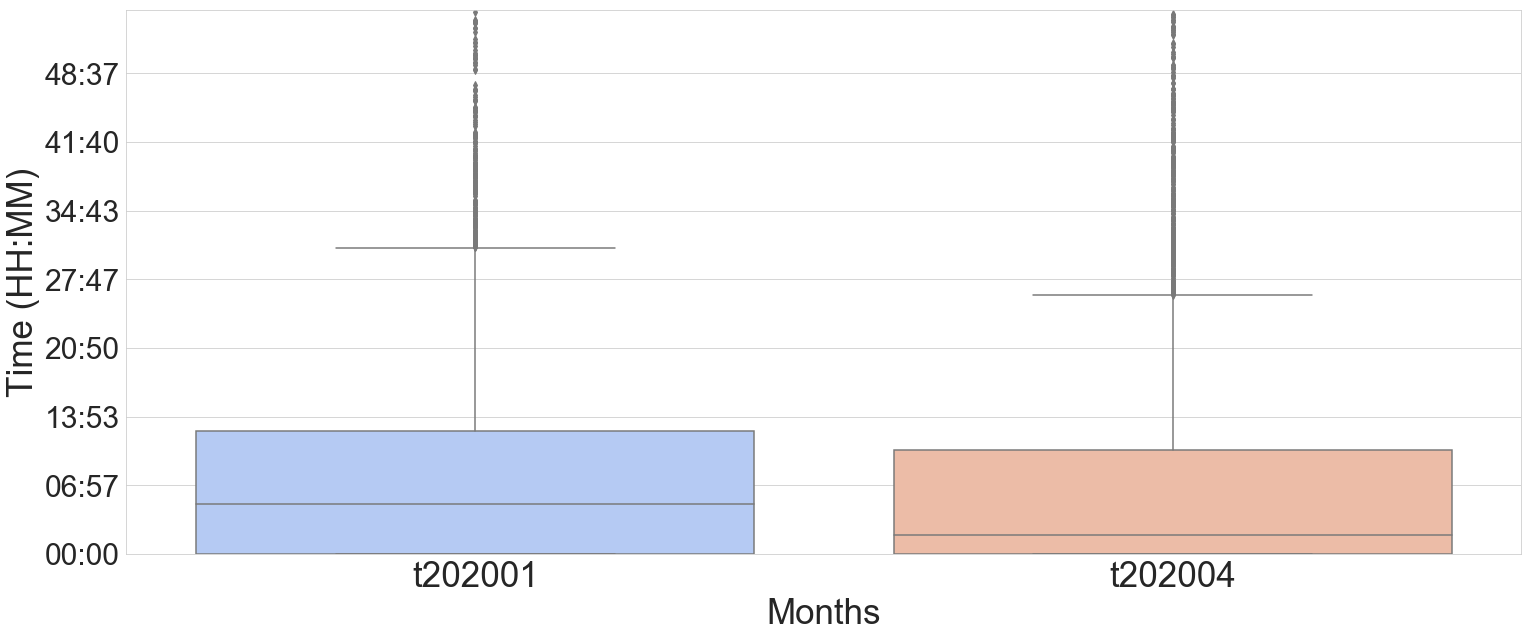

In [56]:
graph_boxplot_time('all','comp_2020jan_2020apr','all')

Time (HH:MM)                                                    
               count      mean        std  min  25%       50%        75%
Months                                                                  
t201901       5676.0  9.059373  14.752521  0.0  0.0  5.216667  12.733333
t202001       5676.0  8.778121  17.591809  0.0  0.0  5.000000  12.400000

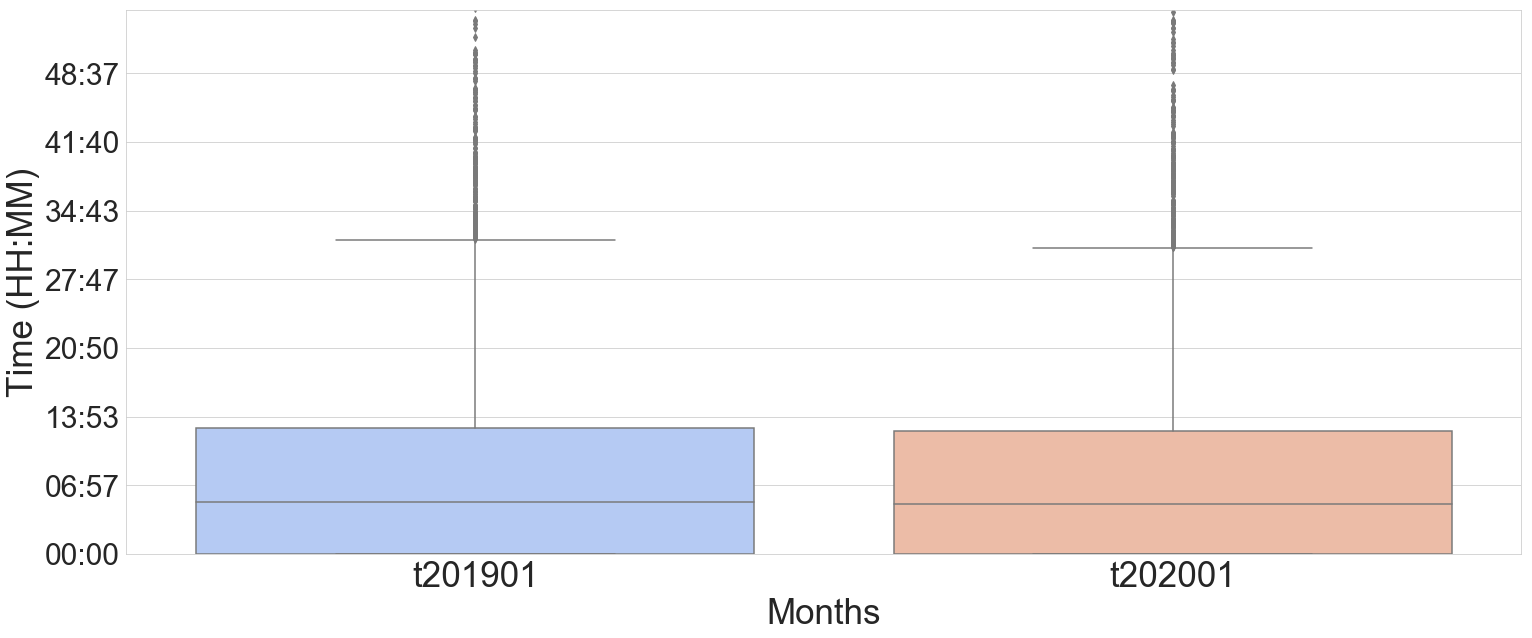

In [55]:
graph_boxplot_time('all','comp_2019jan_2020jan','all')

## Let´s study two groups: Young and Older
First - Split each age_group in one category
Second - Generate a new column with the classification Young and Older

 - Young: 20a24, 25a34, 35a44
 - Older: 55a64, 65a69, 70a74, 75+ 

Exclude:19eabaixo,45a54

Time (HH:MM)                                                          
               count       mean        std  min       25%       50%        75%
Months                                                                        
t201901       1165.0  10.415465  16.539039  0.0  0.000000  7.016667  13.916667
t202001       1165.0  10.018269  11.221452  0.0  0.883333  7.350000  14.283333

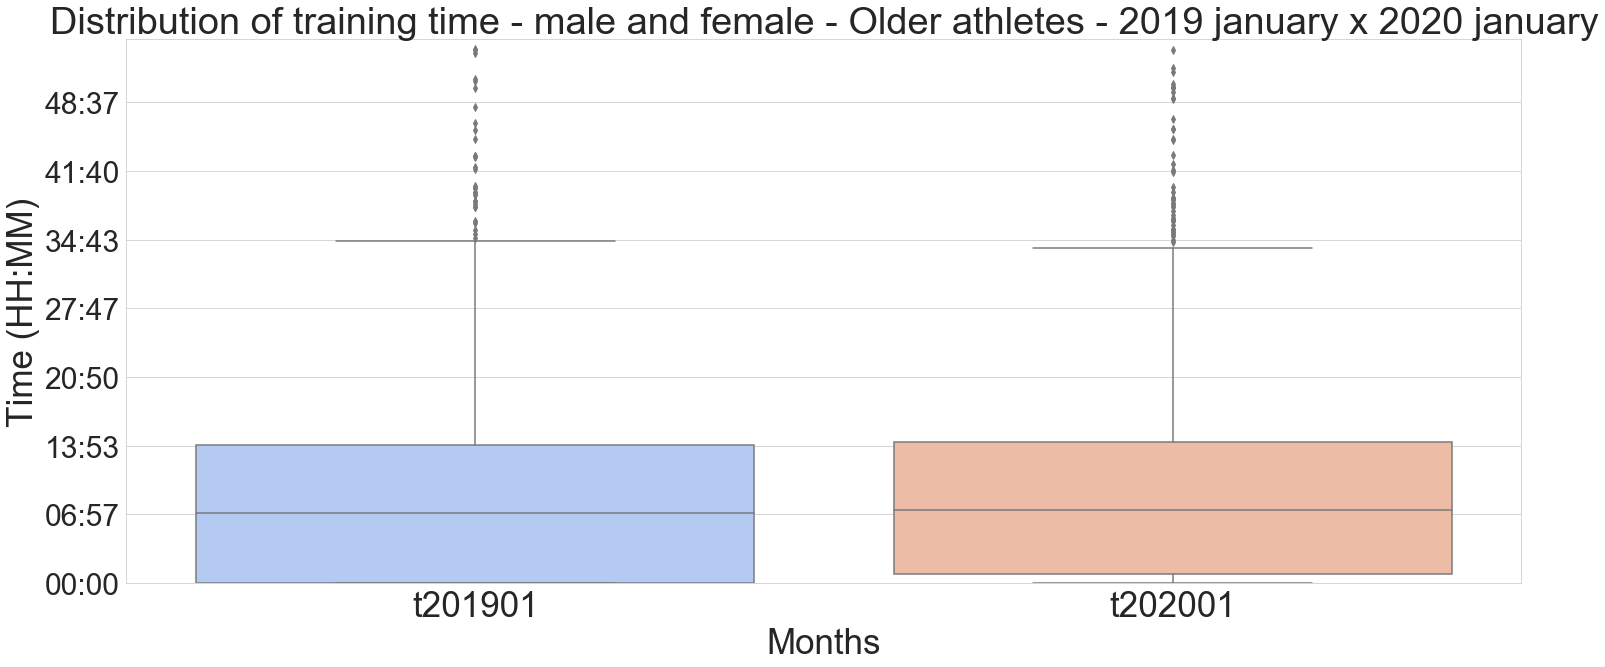

In [133]:
graph_boxplot_time('all','comp_2019jan_2020jan','Older')

Time (HH:MM)                                                    
               count      mean        std  min  25%       50%        75%
Months                                                                  
t202001       3652.0  8.119975  19.249828  0.0  0.0  3.950000  11.470833
t202004       3652.0  6.214987  10.135893  0.0  0.0  1.283333   8.920833

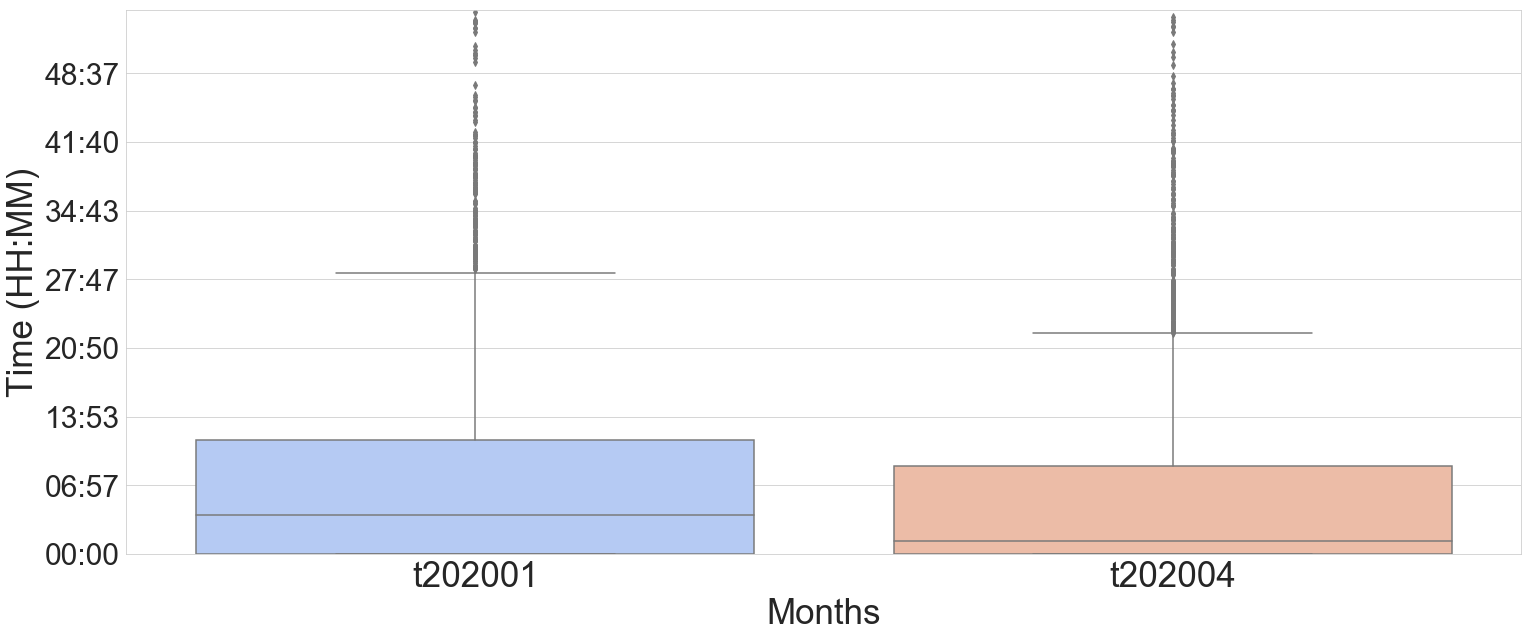

In [58]:
graph_boxplot_time('all','comp_2020jan_2020apr','Young')

Time (HH:MM)                                                      
               count       mean        std  min       25%   50%        75%
Months                                                                    
t202001       1165.0  10.018269  11.221452  0.0  0.883333  7.35  14.283333
t202004       1165.0   8.751788  12.457557  0.0  0.000000  3.30  13.500000

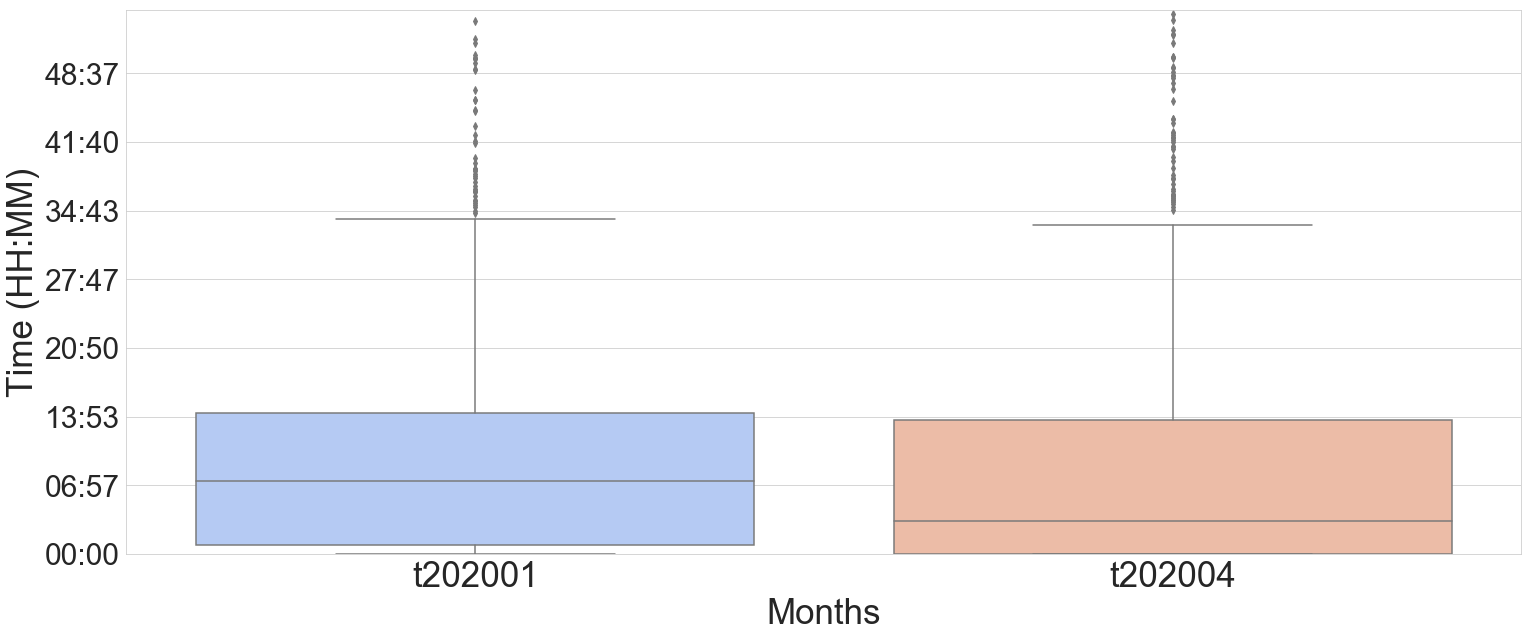

In [59]:
graph_boxplot_time('all','comp_2020jan_2020apr','Older')

## Deal with outliers in data
Based on the last information, Let´s consider 35 hours as a threshold

In [31]:
# Outlier for variables t201901 to t202004
time_outlier='1 days 11:00:00'
filteroutlier=(df_athletes_filter['t201901']>time_outlier)|(df_athletes_filter['t201902']>time_outlier)|(df_athletes_filter['t201903']>time_outlier)|(df_athletes_filter['t201904']>time_outlier)|(df_athletes_filter['t201905']>time_outlier)|(df_athletes_filter['t201906']>time_outlier)|(df_athletes_filter['t201907']>time_outlier)|(df_athletes_filter['t201908']>time_outlier)|(df_athletes_filter['t201909']>time_outlier)|(df_athletes_filter['t201910']>time_outlier)|(df_athletes_filter['t201911']>time_outlier)|(df_athletes_filter['t201912']>time_outlier)|(df_athletes_filter['t202001']>time_outlier)|(df_athletes_filter['t202002']>time_outlier)|(df_athletes_filter['t202003']>time_outlier)|(df_athletes_filter['t202004']>time_outlier)
df_athletes_filter=df_athletes_filter.drop(index=df_athletes_filter[filteroutlier].index,inplace=False)
df_athletes_filter.reset_index(inplace=True)

In [32]:
df_athletes_filter['sexo'].value_counts()

Homens      3762
Mulheres    1030
Name: sexo, dtype: int64

Time (HH:MM)                                                   
               count      mean       std  min  25%       50%        75%
Months                                                                 
t201901       4792.0  6.480916  7.167408  0.0  0.0  4.166667  10.583333
t201902       4792.0  5.666872  6.558338  0.0  0.0  3.350000   9.350000
t201903       4792.0  6.751857  7.565045  0.0  0.0  4.125000  11.216667
t201904       4792.0  6.222687  6.997109  0.0  0.0  3.850000  10.233333
t201905       4792.0  6.487392  7.152216  0.0  0.0  4.116667  10.816667
t201906       4792.0  6.588957  7.206557  0.0  0.0  4.400000  11.054167
t201907       4792.0  6.129845  7.147951  0.0  0.0  3.425000  10.000000
t201908       4792.0  6.070173  7.022607  0.0  0.0  3.533333   9.966667
t201909       4792.0  5.884269  6.711189  0.0  0.0  3.608333   9.666667
t201910       4792.0  6.062594  6.848443  0.0  0.0  3.733333  10.020833
t201911       4792.0  5.775080  6.494704  0.0  0.0  3.600000   9.666667
t201912       4792.0  5.711467  6.463173  0.0  0.0  3.583333   9.420833
t202001       4792.0  6.152908  7.095102  0.0  0.0  3.716667  10.104167
t202002       4792.0  5.880934  7.135525  0.0  0.0  3.033333   9.737500
t202003       4792.0  5.285751  6.546479  0.0  0.0  2.666667   8.833333
t202004       4792.0  4.911676  7.088219  0.0  0.0  0.983333   8.066667

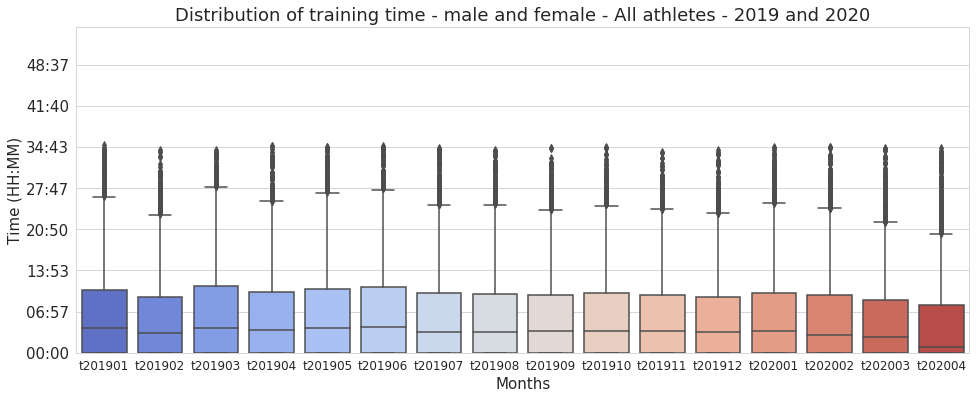

In [33]:
graph_boxplot_time('all','all','all')

Time (HH:MM)                                                   
               count      mean       std  min  25%       50%        75%
Months                                                                 
t201901       4792.0  6.480916  7.167408  0.0  0.0  4.166667  10.583333
t202001       4792.0  6.152908  7.095102  0.0  0.0  3.716667  10.104167

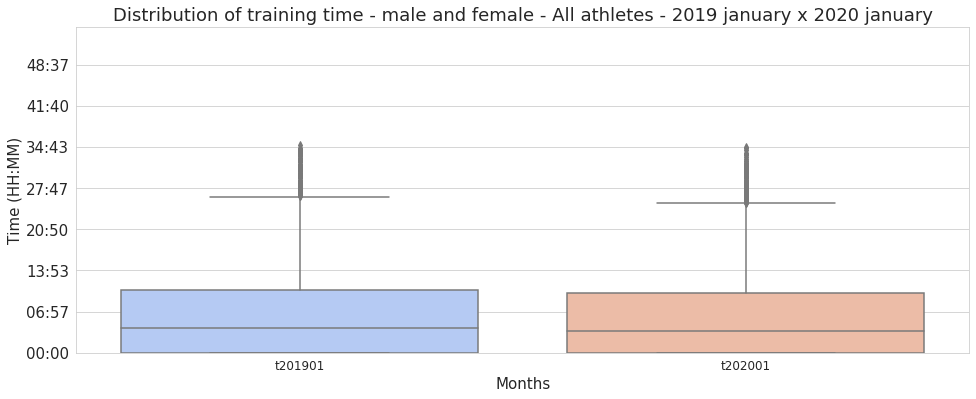

In [34]:
graph_boxplot_time('all','comp_2019jan_2020jan','all')

Time (HH:MM)                                                   
               count      mean       std  min  25%       50%        75%
Months                                                                 
t202001       4792.0  6.152908  7.095102  0.0  0.0  3.716667  10.104167
t202004       4792.0  4.911676  7.088219  0.0  0.0  0.983333   8.066667

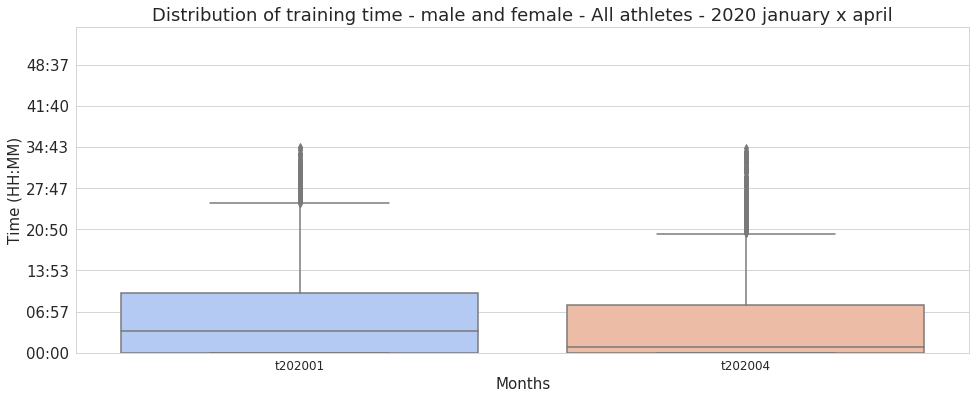

In [35]:
graph_boxplot_time('all','comp_2020jan_2020apr','all')

Time (HH:MM)                                                   
               count      mean       std  min  25%       50%        75%
Months                                                                 
t201904       4792.0  6.222687  6.997109  0.0  0.0  3.850000  10.233333
t202004       4792.0  4.911676  7.088219  0.0  0.0  0.983333   8.066667

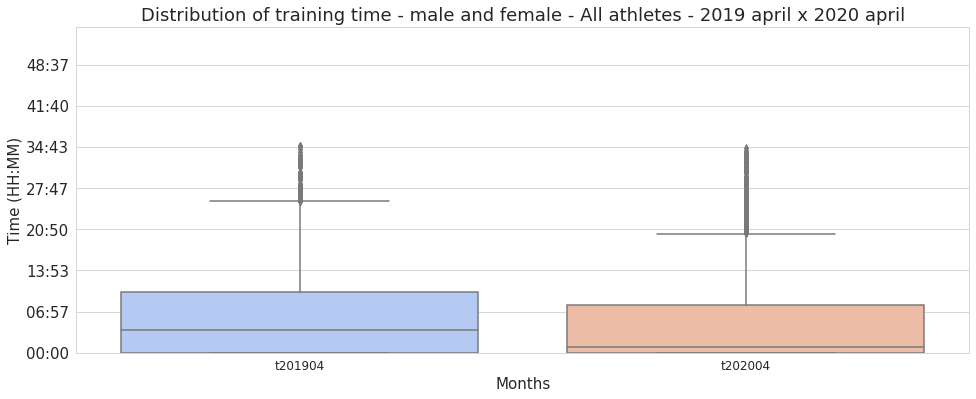

In [36]:
graph_boxplot_time('all','comp_2019apr_2020apr','all')

Time (HH:MM)                                              
               count      mean       std  min  25%  50%        75%
Months                                                            
t202001        913.0  7.350256  7.388374  0.0  0.0  5.8  11.733333
t202004        913.0  5.921230  7.787587  0.0  0.0  1.7  10.500000

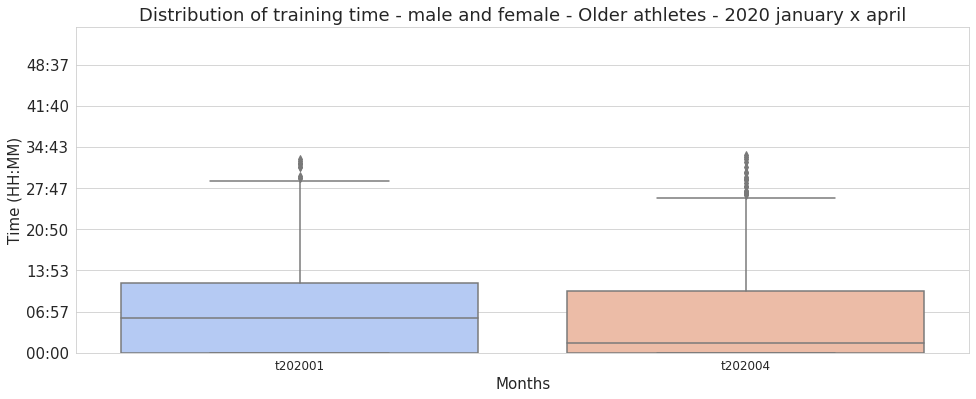

In [37]:
graph_boxplot_time('all','comp_2020jan_2020apr','Older')

Time (HH:MM)                                                  
               count      mean       std  min  25%       50%       75%
Months                                                                
t202001       3176.0  5.647890  6.923277  0.0  0.0  2.958333  9.100000
t202004       3176.0  4.427776  6.767299  0.0  0.0  0.650000  6.804167

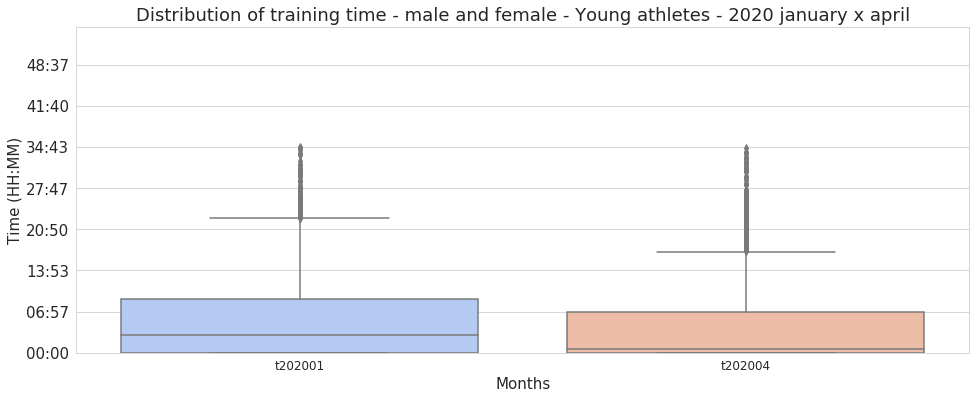

In [44]:
graph_boxplot_time('all','comp_2020jan_2020apr','Young')

### Test for difference mean time between months

__H(0)__


mean(t202001) >= mean(t201901)

In [39]:
pre=(df_athletes_filter['t202001'].apply(lambda x: x.total_seconds())).values
pos=(df_athletes_filter['t201901'].apply(lambda x: x.total_seconds())).values

stats=pg.ttest(pre,pos,paired=True,tail='one-sided')
stats

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-3.144903,4791,less,0.000836,"[-inf, -563.11]",0.045995,4.542,0.93806


__H(0)__


mean(t202004) >= mean(t201904)

In [40]:
pre=(df_athletes_filter['t202004'].apply(lambda x: x.total_seconds())).values
pos=(df_athletes_filter['t201904'].apply(lambda x: x.total_seconds())).values

stats=pg.ttest(pre,pos,paired=True,tail='one-sided')
stats

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-11.660388,4791,less,2.654254e-31,"[-inf, -4053.74]",0.186149,4.059e+27,1.0


__H(0)__


mean(t202004) >= mean(t202001)

In [41]:
pre=(df_athletes_filter['t202004'].apply(lambda x: x.total_seconds())).values
pos=(df_athletes_filter['t202001'].apply(lambda x: x.total_seconds())).values

stats=pg.ttest(pre,pos,paired=True,tail='one-sided')
stats

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-12.540127,4791,less,8.088669e-36,"[-inf, -3882.21]",0.175027,1.235e+32,1.0


__H(0)__

Idosos
mean(t202004) >= mean(t202001)

In [42]:
pre=(df_athletes_filter[(df_athletes_filter['age_group']=="Older")&(df_athletes_filter.faixa_etaria!='19eabaixo')&(df_athletes_filter.faixa_etaria!='45a54')]['t202004'].apply(lambda x: x.total_seconds())).values
pos=(df_athletes_filter[(df_athletes_filter['age_group']=="Older")&(df_athletes_filter.faixa_etaria!='19eabaixo')&(df_athletes_filter.faixa_etaria!='45a54')]['t202001'].apply(lambda x: x.total_seconds())).values

stats=pg.ttest(pre,pos,paired=True,tail='one-sided')
stats

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-6.001612,912,less,1.408126e-09,"[-inf, -3733.11]",0.188262,3.304e+06,1.0


__H(0)__

Jovens
mean(t202004) >= mean(t202001)

In [159]:
pre=(df_athletes_filter[(df_athletes_filter['age_group']=="Young")&(df_athletes_filter.faixa_etaria!='19eabaixo')&(df_athletes_filter.faixa_etaria!='45a54')]['t202004'].apply(lambda x: x.total_seconds())).values
pos=(df_athletes_filter[(df_athletes_filter['age_group']=="Young")&(df_athletes_filter.faixa_etaria!='19eabaixo')&(df_athletes_filter.faixa_etaria!='45a54')]['t202001'].apply(lambda x: x.total_seconds())).values

stats=pg.ttest(pre,pos,paired=True,tail='one-sided')
stats

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-10.134267,3175,less,4.458882e-24,"[-inf, -3679.29]",0.17823,3.394e+20,1.0


## Test for difference using confidence intervals and bootstrap

In [134]:
def nonRepeatedRandomInt(low, upper, N):
        import numpy as np
        import random
        
        numbers = np.arange(low, upper, 1)
        random.shuffle(numbers)
        shuffleNumbers = np.array(numbers)[0:int(N)]
        shuffleNumbers = np.sort(shuffleNumbers)
        
        return shuffleNumbers

In [160]:
def CIcomputation(x1, x2, N=1000, alpha=0.05, verbose=True):
    mean1 = np.zeros(N)
    mean2 = np.zeros(N)
    for i in range(N):
        L = list(nonRepeatedRandomInt(0, len(x1), len(x1)//2))
        mean1[i] = np.mean(x1.loc[L].dt.total_seconds()/60)
        mean2[i] = np.mean(x2.loc[L].dt.total_seconds()/60)
    
    IC1 = [np.quantile(mean1, alpha/2), np.quantile(mean1, 1-alpha/2)]
    IC2 = [np.quantile(mean2, alpha/2), np.quantile(mean2, 1-alpha/2)]
    
    if verbose:
        print('IC', 100-alpha*100 ,'%', x1.name , '= [',int(np.quantile(mean1, 0.025)//60), 'h',round(np.mod(np.quantile(mean1, 0.025), 60)),'min',','
              ,int(np.quantile(mean1, 0.975)//60), 'h',round(np.mod(np.quantile(mean1, 0.975), 60)),'min',']')
        print('IC', 100-alpha*100 ,'%', x2.name , '= [',int(np.quantile(mean2, 0.025)//60), 'h',round(np.mod(np.quantile(mean2, 0.025), 60)),'min',','
              ,int(np.quantile(mean2, 0.975)//60), 'h',round(np.mod(np.quantile(mean2, 0.975), 60)),'min',']')
           
    return IC1, IC2

January 2019 and January 2020

In [149]:
IC1, IC2 = CIcomputation(df_athletes_filter['t201901'], df_athletes_filter['t202001'])

IC 95.0 % t201901 = [ 6 h 16.0 min , 6 h 41.0 min ]
IC 95.0 % t202001 = [ 5 h 57.0 min , 6 h 22.0 min ]


April 2019 and April 2020

In [150]:
IC1, IC2 = CIcomputation(df_athletes_filter['t201904'], df_athletes_filter['t202004'])

IC 95.0 % t201904 = [ 6 h 1.0 min , 6 h 25.0 min ]
IC 95.0 % t202004 = [ 4 h 43.0 min , 5 h 6.0 min ]


January 2020 and April 2020

In [151]:
IC1, IC2 = CIcomputation(df_athletes_filter['t202001'], df_athletes_filter['t202004'])

IC 95.0 % t202001 = [ 5 h 57.0 min , 6 h 21.0 min ]
IC 95.0 % t202004 = [ 4 h 43.0 min , 5 h 6.0 min ]


Older, January 2020 and April 2020

In [156]:
IC1, IC2 = CIcomputation(df_athletes_filter[(df_athletes_filter['age_group']=="Older")&(df_athletes_filter.faixa_etaria!='19eabaixo')&(df_athletes_filter.faixa_etaria!='45a54')].reset_index()['t202001'], 
                         df_athletes_filter[(df_athletes_filter['age_group']=="Older")&(df_athletes_filter.faixa_etaria!='19eabaixo')&(df_athletes_filter.faixa_etaria!='45a54')].reset_index()['t202004'])


IC 95.0 % t202001 = [ 6 h 55.0 min , 7 h 49.0 min ]
IC 95.0 % t202004 = [ 5 h 27.0 min , 6 h 24.0 min ]


Young, January 2020 and April 2020

In [158]:
IC1, IC2 = CIcomputation(df_athletes_filter[(df_athletes_filter['age_group']=="Young")&(df_athletes_filter.faixa_etaria!='19eabaixo')&(df_athletes_filter.faixa_etaria!='45a54')].reset_index()['t202001'], 
                         df_athletes_filter[(df_athletes_filter['age_group']=="Young")&(df_athletes_filter.faixa_etaria!='19eabaixo')&(df_athletes_filter.faixa_etaria!='45a54')].reset_index()['t202004'])


IC 95.0 % t202001 = [ 5 h 25.0 min , 5 h 54.0 min ]
IC 95.0 % t202004 = [ 4 h 11.0 min , 4 h 39.0 min ]
